In [1]:
# %pip install healpy
# %pip install astropy
import healpy as hp
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord

In [2]:
# Read in 22.5 million data elements
data = pd.read_csv('/Users/monicahicks/GLADE+512.csv')
# Print first 5 row for format check
data.head(5)

,G_or_Q,RA,DEC,Pix,Z
0,G,192.721451,41.120152,538552,0.000991
1,G,188.860123,14.496320,1179597,0.004120
2,G,267.360474,70.144341,93102,0.001000
3,G,187.016220,9.803620,1304536,0.003557
4,G,187.367000,8.749890,1333206,0.004139


In [3]:
# This is SO FREAKING FAST literally 1000x faster than a loop
good_data = data.loc[(data.Z > 0.25) & (data.Z < 0.5)]

In [4]:
# sanity check on elements in desired set
print(len(good_data))

6097735


In [5]:
# get galaxy icrs coordinates from RA/Dec coordinates
# creates 3 equal length paralell arrays
ra = good_data['RA']
dec = good_data['DEC']
coords = SkyCoord(ra=ra, dec=dec, unit="deg", frame='icrs')

In [6]:
vec = hp.ang2vec(theta=np.pi / 2.0 - np.radians(coords.galactic.b.value), phi=np.radians(coords.galactic.l.value),lonlat=False)
pixels = hp.ang2pix(nside=2048,theta=np.pi / 2.0 - np.radians(coords.galactic.b.value), phi=np.radians(coords.galactic.l.value),lonlat=False)

In [7]:
z = good_data['Z']
print(len(z))

6097735


In [8]:
def get_z_bin(z):
    bins = np.linspace(0.25,0.5,17)
    for i in range(len(bins)):
        if z < bins[i]:
            return i - 1
    return 15

In [9]:
print(0.27,get_z_bin(0.27))
print(0.291,get_z_bin(0.291))
print(0.05,get_z_bin(0.05))

0.27 1
0.291 2
0.05 -1


In [11]:
pixel_dict = {}
nside = 2048
dust_map = hp.read_map('d10_2048_343_I-2.fits')
# subtract map smoothed to 4 degrees from original
dust_map -= hp.sphtfunc.smoothing(dust_map, fwhm = 0.069813, iter = 1)

In [12]:
print(len(dust_map))
print(hp.nside2npix(2048))

50331648
50331648


In [13]:
for i in range(len(good_data)):
    # get pixel associated with galaxy
    pix = pixels[i]
    
    #print(pix)
    
    # get z_value associate with galaxy
    gal_z = z.iloc[i]
    
    # if the pixel isn't already in the dictionary
    # create z-list and get reddening values
    if pix not in pixel_dict:

        # get disc of surrounding for <E(B-V)>
        ipix_disc = hp.query_disc(nside=nside,vec=vec[i],radius=np.radians(1))
        
        # get actual reddening value
        act_red = dust_map[pix]
        
        # get average reddening value for disc
        exp_red = np.mean(dust_map[ipix_disc])
        
        # make list to track z values in pixel
        z_bins = np.zeros(16)
        
        # increment counter in correct z-bin
        z_bins[get_z_bin(gal_z)] += 1
        
        # add list containing z-list, actual red, <red>
        pixel_dict[pix] = [ z_bins, vec[i], act_red, exp_red ]
        
    # otherwise just increment z-bin
    else:
        pixel_dict[pix][0][get_z_bin(gal_z)] += 1
        
    # this just tracks progress
    if i % 100000 == 0:
        print('.',end='')

.............................................................

In [14]:
print(len(pixel_dict.keys()))

5405440


In [15]:
def get_surrounding_n(pix,bin):
    # get the pixels with one square degree
    z_disc = hp.query_disc(nside=nside,vec=pixel_dict[pix][1],radius=np.radians(0.5556))
    
    # start counter for galaxies
    gal_count = 0
    
    # for each pixel, count galaxies in desired redshift bin
    for p in z_disc:
        if p in pixel_dict.keys():
        # in pixel_dict for pixel p, in the z-bins, at the desired z-bin
            gal_count += pixel_dict[p][0][bin]
            
    return gal_count / len(z_disc)

In [16]:
delta_red = []
delta_r = []
for i in range(16):
    delta_r.append([])
print(delta_r)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [17]:
f1 = 0
with open('2048_343_data_mt_25.csv','w') as f:
    for pix in pixel_dict.keys():
        f.write(str(pix))
        f.write(',')
        for i in range(len(delta_r)):
            n_theta = pixel_dict[pix][0][i]
            exp_n = get_surrounding_n(pix,i) - 1
            if exp_n != 0:
                delta_r[i].append(n_theta / exp_n)
                f.write(str(n_theta / exp_n))
                f.write(',')
            else:
                delta_r[i].append('null')
                f.write('null')
                f.write(',')
        delta_red.append(pixel_dict[pix][2] - pixel_dict[pix][3])
        f.write(str(pixel_dict[pix][2] - pixel_dict[pix][3]))
        f.write('\n')
        f1 += 1
        if f1 % 100000 == 0:
            print('.',end='')
f.close()

......................................................

In [18]:
corr_data = []
auto_corr_r = []
auto_corr_red = []
for i in range(16):
    data_set = [[],[]]
    for j in range(len(delta_r[i])):
        if delta_r[i][j] != 'null':
            data_set[0].append(delta_r[i][j])
            data_set[1].append(delta_red[j])
    if len(auto_corr_red) ==  0:
        auto_corr_red = np.correlate(data_set[1],data_set[1])
    auto_corr_r.append(np.correlate(data_set[0],data_set[0]))
    corr_data.append(np.correlate(data_set[0],data_set[1]))
with open('2048_343_corr_data_mt25.csv', 'w') as f: 
    f.write('corr_data: ')
    f.write(str(corr_data))
    f.write('\n')
    f.write('auto_corr_r: ')
    f.write(str(auto_corr_r))
    f.write('\n')
    f.write('auto_corr_red: ')
    f.write(str(auto_corr_red))
    f.write('\n')
    f.close()
print(corr_data)
print(auto_corr_r)
print(auto_corr_red)

[array([576514.92755357]), array([520709.53439014]), array([414624.33564121]), array([307950.38984074]), array([207060.64284793]), array([159544.3798582]), array([112590.26340932]), array([79014.860787]), array([64763.89887758]), array([41554.64758364]), array([33900.98110298]), array([13373.94732963]), array([9929.62061345]), array([5198.28877265]), array([5595.34020391]), array([2115.62276936])]
[array([1533010.05142511]), array([1389454.90809023]), array([1082764.81811052]), array([740034.40366234]), array([510918.70977975]), array([357075.35782075]), array([253099.75495408]), array([181783.96186003]), array([140819.63725959]), array([105722.6236331]), array([91602.71278082]), array([88115.17066827]), array([95121.98785872]), array([103522.46456397]), array([64901.822567]), array([7964.7139864])]
[3.8800378e+08]


In [19]:
x = np.linspace(0.25,0.5,17)
x = x[1:]

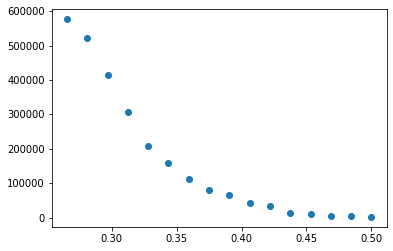

In [20]:
plt.scatter(x,corr_data)
plt.show()